In [3]:
from pymoo.problems.many.dtlz import DTLZ2
from pymoo.util.ref_dirs import get_reference_directions
import pandas as pd
from pymoo.indicators.hv import Hypervolume
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from pymoo.operators.sampling.lhs import LHS
import matplotlib.pyplot as plt
from pymoo.indicators.hv import HV
from pymoo.util.display.output import Output, pareto_front_if_possible
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np
import random

In [103]:
weight_vectors = get_reference_directions('energy',2,100)

In [104]:
problem = DTLZ2(n_obj=2)
sampling  = LHS()
ref_dirs = sampling(problem,100).get('X')

In [105]:
ref_dirs

array([[0.77346841, 0.84642247, 0.30496125, 0.21114173, 0.29188628,
        0.7786389 , 0.13972355, 0.87302447, 0.47969414, 0.49317873],
       [0.55526629, 0.63261236, 0.63513249, 0.76660754, 0.66411878,
        0.24944074, 0.54844306, 0.28385003, 0.41145227, 0.36119091],
       [0.19354181, 0.41562996, 0.66446842, 0.12640738, 0.63263128,
        0.86305175, 0.44237353, 0.07341195, 0.87278111, 0.57380699],
       [0.53780435, 0.45601544, 0.81132907, 0.05799123, 0.27859733,
        0.44790603, 0.89829674, 0.99610323, 0.66258857, 0.05863649],
       [0.22752614, 0.97590689, 0.5003057 , 0.87041231, 0.39630163,
        0.4643396 , 0.36974086, 0.20611951, 0.20642431, 0.22758724],
       [0.02735409, 0.27350214, 0.02898495, 0.31998168, 0.26930742,
        0.3383665 , 0.19193216, 0.04146644, 0.24136684, 0.78501938],
       [0.07097304, 0.66731074, 0.40484231, 0.25138476, 0.88155684,
        0.14447149, 0.02911005, 0.55496901, 0.05783491, 0.30488255],
       [0.56812359, 0.34961513, 0.2031294

In [106]:
output = {}
problem._evaluate(ref_dirs,output)

In [107]:
objective_value_1 = [i[0] for i in output['F']]
objective_value_2 = [i[1] for i in output['F']]
columns = []
for i in range(1,11):
    columns.append('x'+str(i))
print(columns)
dataset = pd.DataFrame(data = ref_dirs,columns = columns)
dataset['Objective 1'] = objective_value_1
dataset['Objective 2'] = objective_value_2
#dataset = pd.DataFrame(data=dict_data)

['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10']


In [108]:
dataset.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,Objective 1,Objective 2
0,0.773468,0.846422,0.304961,0.211142,0.291886,0.778639,0.139724,0.873024,0.479694,0.493179,0.568491,1.529619
1,0.555266,0.632612,0.635132,0.766608,0.664119,0.249441,0.548443,0.283850,0.411452,0.361191,0.818594,0.974663
2,0.193542,0.415630,0.664468,0.126407,0.632631,0.863052,0.442374,0.073412,0.872781,0.573807,1.577053,0.494786
3,0.537804,0.456015,0.811329,0.057991,0.278597,0.447906,0.898297,0.996103,0.662589,0.058636,1.309175,1.474683
4,0.227526,0.975907,0.500306,0.870412,0.396302,0.464340,0.369741,0.206120,0.206424,0.227587,1.535851,0.573539


##### MOdelling on Objective 1

In [109]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 1'].to_numpy().reshape(-1,1)

In [110]:
#kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2)) 
kernel =  RBF(length_scale=3) 
model = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=25,normalize_y=True).fit(X,Y)

In [111]:
#x1 = dataset['x1'].to_numpy()
#x2= dataset['x2'].to_numpy()
#x1 = np.linspace(x1.min(), x2.max())
#x2 = np.linspace(x2.min(), x1.max())

In [112]:
#x= (np.array([x1,x2])).T
#output = {}
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

In [113]:
#ax = plt.figure().add_subplot(projection='3d')
#mean,std = model.predict(x,return_std=True)
#ax.scatter(x1,x2,mean)
#ax.scatter(x1,x2,data)
#ax.plot(x1,x2,mean,color = 'red')


In [114]:
kernel_2 = C(1.0) * RBF(length_scale=0.1) 
#kernel =  RBF(length_scale=3) 
model_2 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=40,normalize_y=True,random_state=11).fit(X,Y)
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]

In [115]:
#x1 = dataset['x1'].to_numpy()
#x2= dataset['x2'].to_numpy()
#x1 = np.linspace(x1.min(), x2.max())
#x2 = np.linspace(x2.min(), x1.max())
#ax = plt.figure().add_subplot(projection='3d')
#x= (np.array([x1,x2])).T
#mean_2,std_2 = model_2.predict(x,return_std=True)
#ax.scatter(x1,x2,mean_2)
#ax.scatter(x1,x2,data)
#ax.plot(x1,x2,mean_2,color = 'red')


#### Model on Objective 2

In [116]:
X = dataset[columns].to_numpy()
Y = dataset['Objective 2'].to_numpy().reshape(-1,1)
kernel_2 = C(1.0) * RBF(length_scale=0.1) 
#kernel =  RBF(length_scale=3) 
model_3 = GaussianProcessRegressor(kernel=kernel_2,n_restarts_optimizer=30,normalize_y=True,random_state=12).fit(X,Y)

In [117]:
#x1 = dataset['x1'].to_numpy()
#x2= dataset['x2'].to_numpy()
#x1 = np.linspace(x1.min(), x2.max())
#x2 = np.linspace(x2.min(), x1.max())
#ax = plt.figure().add_subplot(projection='3d')
#x= (np.array([x1,x2])).T
#output = {}
#x= (np.array([x1,x2])).T
#problem._evaluate(x,output)
#data = [i[0] for i in output['F']]
#mean_2,std_2 = model_3.predict(x,return_std=True)
#ax.scatter(x1,x2,mean_2)
#ax.scatter(x1,x2,data)
#ax.plot(x1,x2,mean_2,color = 'red')


#### Creating Custom Problem that will use my Gaussian Models as Objective Functions

In [118]:
class CustomProblemExploit(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=4,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,-std_1,mean,-std]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],-std_1[i],mean[i],-std[i]])
        out["F"] = objective_values

In [119]:
class CustomProblemExplore(Problem):

    def __init__(self):
        super().__init__(n_var=10, n_obj=2,xl=0,xu=1)

    def _evaluate(self, x, out, *args, **kwargs):
        objective_values = []
        if(len(x)==1):
            value = np.array(x).reshape(1,-1)
            mean_1,std_1 = model_2.predict(value,return_std=True) 
            mean,std = model_3.predict(value,return_std=True)
            objective_values = [mean_1,mean]
        else:
            mean_1,std_1 = model_2.predict(x,return_std=True) 
            mean,std = model_3.predict(x,return_std=True)
            #print(mean)
            for  i in range(len(mean_1)):
                objective_values.append([mean_1[i],mean[i]])
        out["F"] = objective_values

In [120]:
def epsilon_greedy_method(epsilon,problem_1,problem_2,algorithm):
    if(np.random.uniform(0,1)<epsilon):
        res=minimize(problem_1,algorithm,
                ('n_gen', 10),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
    else:
        res=minimize(problem_2,algorithm,
                ('n_gen', 10),
                seed=1,
                verbose=False,
                save_history=True)
        index = random.randrange(0,len(res.F))
        values =  res.X
        return values[index]
        

In [121]:
problem_1 = CustomProblemExploit()
problem_2 = CustomProblemExplore()
refference_points = [max(dataset['Objective 1']),max(dataset['Objetive 2'])]

algorithm = NSGA2(pop_size = 100)
algorithm_2 = MOEAD(ref_dirs=weight_vectors)
data = []
for i in range(50):
    data.append(epsilon_greedy_method(0.1,problem_1,problem_2,algorithm_2))



In [122]:
#data = np.array([list(i) for i  in data])
new_data = list(ref_dirs) + data
new_data = np.array(new_data)
output = {}
new_objectives  = problem._evaluate(new_data,output)
new_dataset = pd.DataFrame(data = new_data,columns = columns)
new_obj1 = [i[0] for i in output['F']]
new_obj2 = [i[1] for i in output['F']]
new_dataset['Objective 1']  = new_obj1
new_dataset['Objective 2'] = new_obj2

In [123]:
def dominates_Flag(A,B):
    flag = False
    count = 0 
    for i in range(0,len(A)):
        if(A[i]<B[i]):
            flag = True
            count = count +1
        elif(A[i]==B[i]):
            flag = True
        else:
            flag = False
            break
    if(flag == True and count >= 1):
        return True
    else:
        return False


def non_dominated_fronts(final_data,num_solns):
    ranks = []
    data_copy = final_data
    while(len(data_copy)>=num_solns):
        internal_ranks = []
        for i in data_copy:
            Flag =False
            for j in data_copy:
                if(i!=j and i not in internal_ranks and dominates_Flag(j,i)==False):
                    Flag = True
                elif(i!=j and i not in internal_ranks and dominates_Flag(j,i)==True):
                    Flag=False
                    break
            if(Flag==True):
                internal_ranks.append(i)
        ranks.append(internal_ranks)
        #print(internal_ranks)
        for i in internal_ranks:
            data_copy.remove(i)
    return ranks
            



In [124]:
objectives = []
objectives1 = list(dataset['Objective 1'])
objectives2 = list(dataset['Objective 2'])
for i in range(len(dataset['Objective 1'])):
    objectives.append([objectives1[i],objectives2[i]])
fronts = non_dominated_fronts(objectives,60)


In [125]:
objectives_new = []
objectives1_new = list(new_dataset['Objective 1'])
objectives2_new = list(new_dataset['Objective 2'])
for i in range(len(new_dataset['Objective 1'])):
    objectives_new.append([objectives1_new[i],objectives2_new[i]])
fronts_new = non_dominated_fronts(objectives_new,60)


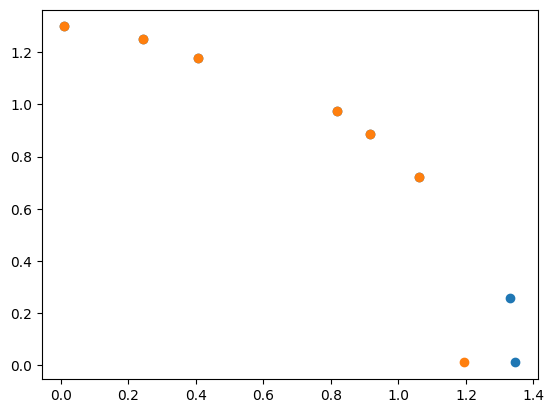

In [130]:
len(fronts)
objective_front_1  = [i[0] for i in fronts[0]]
objective_front_2 = [i[1] for i in fronts[0]]

objective_front_1_new  = [i[0] for i in fronts_new[0]]
objective_front_2_new = [i[1] for i in fronts_new[0]]

plt.scatter(objective_front_1, objective_front_2)
plt.scatter(objective_front_1_new, objective_front_2_new)